In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy  as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [52]:
def normalize(df) -> pd.DataFrame:
    return (df - df.min()) / (df.max() - df.min())

def shorten(df, start_date=None, end_date=None) -> pd.DataFrame:
    if start_date is None:
        return df.query('index <= @end_date')
    if end_date is None:
        return df.query('index >= @start_date')
    else:
        return df.query('index >= @start_date and index <= @end_date')

def fit_correlation(df: pd.DataFrame, col:str, inflation: pd.DataFrame, month) -> float: 
    start_date = df.index.min()- relativedelta(months=1)
    end_date = df.index.max()
    inflation = inflation.query('index >= @start_date and index <= @end_date')
    
    if month == None:
        df = df.resample('3M').asfreq()
        print(df)
    
    else:
        df = df[df.index.month == month]
        inflation = inflation[inflation.index.month == month]

    
    for dfs in [inflation, df]:
        dfs.index  = pd.to_datetime(df.index).to_period('M')
        
    corr = inflation['Year-ended inflation'].corr(df[col])
    return corr

### Introduction

Across the world we seem to be experiencing a period of high inflation. In April 2023, Australia’s inflation rate has reached over 6.8%. We are experiencing inflation never seen before in decades (since the 1980’s) according to the Reserve Bank of Australia (RBA) data. 
We must find the underlying cause of this crisis. Is it due to “the war in Ukraine”? What about “high government spending during the Covid-19 pandemic”? 

This analysis will look at the Australian inflation rate from 1922 to 2023. We will examine two mainstream theories about how inflation is created (Monetarist and Keynesian) to determine which one is more accurate. We will also look at some non-government related factors that might cause our current inflation. Finally, we will bring all our analysis together to model how inflation might continue in the future, and also how we can combat inflation.

### Analyzing our Inflation using RBA data

To analyse Australian inflation, we will use trusted and reliable RBA data for our analysis. Lets look at Austrlian inflation over the decades.


In [53]:
# Consumer Price Inflation – G1 RBA
inflation_data = pd.read_csv("inflation_data.csv")
inflation_data.rename(columns={'Title': 'Date'}, inplace=True)
#Removing the first row with only NaNs
inflation_data = inflation_data.drop(inflation_data.index[0])
inflation_data.head()


,Date,Consumer price index,Year-ended inflation,Year-ended inflation – excluding interest and tax changes,Year-ended inflation – excluding volatile items,Year-ended tradables inflation,Year-ended tradables inflation – excluding volatile items and tobacco,Year-ended non-tradables inflation,Year-ended non-tradable inflation – excluding interest charges and deposit & loan facilities,Year-ended weighted median inflation,...,Quarterly inflation – original,Quarterly inflation,Quarterly inflation – excluding interest and tax changes,Quarterly inflation – excluding volatile items,Quarterly tradables inflation,Quarterly tradables inflation – excluding volatile items and tobacco,Quarterly non-tradables inflation,Quarterly non-tradables inflation – excluding deposit and loan facilities,Quarterly weighted median inflation,Quarterly trimmed mean inflation
1,1/06/1922,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/09/1922,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/12/1922,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/03/1923,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1/06/1923,2.8,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This data is a series of inflation indicators measured quarterly from June 1922 to June 2023.

We need to do some data cleaning. Firstly, we need to convert our quarterly data into DateTime format.
We will firstly find the type of our Date data.

In [54]:
inflation_data["Date"].apply(type).unique()

array([<class 'str'>], dtype=object)

We see that our datatype for our data is string. This can be converted to DateTime with the following code.

In [55]:
#Convert to DateTime
inflation_data["Date"] = pd.to_datetime(inflation_data["Date"], format='%d/%m/%Y')
inflation_data.set_index("Date", inplace=True)

We will now look at the yearly-ending inflation data. We will use year-ending instead of quarterly inflation since we want to discover the long-term trends in inflation.

Text(0, 0.5, 'Inflation Rate (%)')

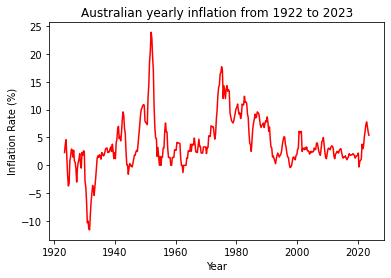

In [56]:
plt.plot(inflation_data["Year-ended inflation"], color = "red")
plt.title("Australian yearly inflation from 1922 to 2023")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")

We only see significant drops in inflation during the Great Depression (1930's). Otherwise inflation has been positive. It is important to realize with this data that the CPI has rarely declined. 

We will now examine various mainstream perspectives of what causes inflation, and test whether those theories add up in reality. We will look at Monetarist and Keynesian theories of inflation.

### Monaterist Perspective
According to Monterist theory, inflation is due to the increase in money supply from money printing. To understand this, we need to look at their predicted behaviour of how much we value money (demand) against the supply of money. 

### insert diagram here

This diagram is a simple supply and demand diagram that is the basis of economics. Indeed we can use this diagram for any goods or services, and money is no different. To understand this diagram, it is showing that a price is set on that particular good so that it is at the point of equillibrium. This is where the quantity demanded of a particular good or service is equal to the amount of that good avaliable (Qs = Qd). If the price is higher, then there will be a surplus of that good since not as much people will buy it since it is too expensive (Qs > Qd). If the price is lower than the equillibrium, then more people will want that good then what is avaliable (Qs <Qd). This is why businesses will set their good's price at the equillibrium point (Qs = Qd), since they are losing money otherwise.

We can compare this to money. The price set for money itself is the value we place in it. For example, we determine ourselves whether one dollar is an acceptable price for buying a toy car or not. We know that all the money in Australia is created from the Reserve Bank of Australia (RBA), and noone else can make money themselves. Naturally, that means that the amount which is demanded (in society's possession) is the same as all the money supplied into the economy. Therefore, the supply of money does not change despite the value we place in it. This is represented by the vertical straight line for the supply of money.

According to the monetarist's perspective, the only way that the value of money is decreased is when we increase the supply of money. This is shown by this updated diagram.

### insert diagram2 here

As you can see, we are shifting the supply of money (Long Run Aggregate Supply or LRAS) to the right. What happens now is the the equillibrium point for the value of money is now lower than it was before (Assuming the money demanded stays the same). This means that we value money less, and thus that means that more money is required to buy goods. This therefore causes inflation in the long run. 

The only way to increase the supply of money is literally "printing" it from thin air. This is also called "Quantitative Easing" and can only be done by the RBA in Australia. Therefore, in order to test the Montarist theory of inflation, we must check whether the inflation rate correlates with the amount of money printed by the RBA.

We have to realize that when consumers receive their increase in income, they need to spend that new money to increase inflation. According to Monetarist Theory, we can just assume they will do so. 

### Examining Money Creation

Money can be created in several ways by the RBA. Firstly, the RBA directly increases the money supply directly by producing more coins and banknotes in the Royal Australian Mint, as well as indirectly allowing banks to create more digital money. Secondly, it decreases interest rates. Finally, it buys government bonds.


### Physical Money Production
We will firstly look at the graph describing the total value of various coins and bank notes produced from 1984 to the present day using monthly RBA data (in $million). 

In [57]:
money_production = pd.read_csv("moneyproduction.csv")
#Removing nan values and dropping unnessesary columns
#Converting the date to the proper format
money_production["Date"] = pd.to_datetime(money_production["Date"], format='%d/%m/%Y')
money_production.set_index("Date", inplace=True)
money_production

,1$,2$,5$,10$,20$,50$,100$,Total
Date,,,,,,,,
1984-01-25,88.0,162.0,178,517,2227,3661,NaN,6833
1984-02-29,87.0,162.0,177,513,2230,3649,NaN,6819
1984-03-28,89.0,164.0,179,516,2236,3668,56.0,6909
1984-04-25,96.0,173.0,190,543,2402,3711,286.0,7400
1984-05-30,NaN,166.0,181,512,2226,3482,462.0,7029
...,...,...,...,...,...,...,...,...
2023-06-30,NaN,NaN,1022,1389,3699,47515,47659.0,101285
2023-07-31,NaN,NaN,1020,1388,3682,46930,47664.0,100684
2023-08-31,NaN,NaN,1014,1384,3654,46831,47641.0,100524


Text(0, 0.5, 'Value (in $Millions AUD)')

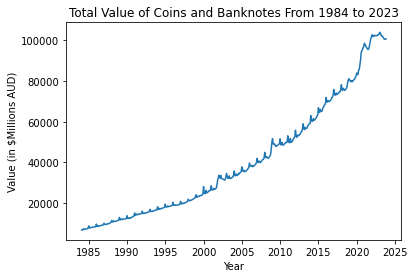

In [58]:
#Plotting Graph
plt.plot(money_production["Total"])
plt.title("Total Value of Coins and Banknotes From 1984 to 2023")
plt.xlabel("Year")
plt.ylabel("Value (in $Millions AUD)")

As you can see, the money supply has increased steadily. We can see seasonal volatility in our data. We will now look at the rate of increase of the money supply for each month.

Text(0, 0.5, 'Change of amount (%)')

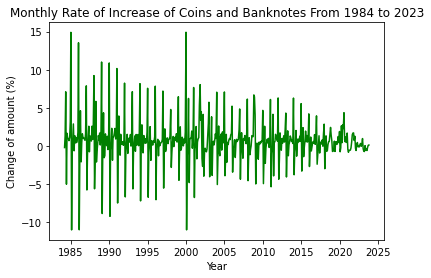

In [59]:
#Plotting Monthly Growth Rate
money_production['Growth_Rate'] = money_production['Total'].pct_change(periods=1) * 100

plt.plot(money_production["Growth_Rate"], color = "green")
plt.title("Monthly Rate of Increase of Coins and Banknotes From 1984 to 2023")
plt.xlabel("Year")
plt.ylabel("Change of amount (%)")

As you can see there seems to be a sudden seasonal increase in the amount of money circulated in regular intervals, and then just as dramatic decline soon after. Lets examine this further. We will do a seasonal plot describing the growth of money in circulation during different months.

Text(0, 0.5, 'Growth (%)')

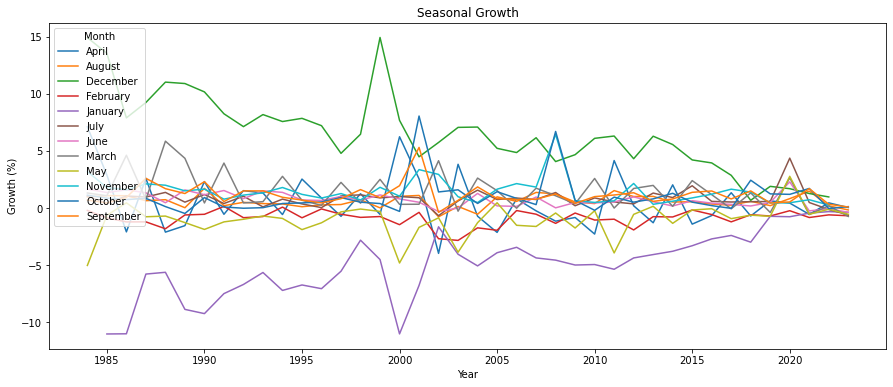

In [60]:
#Seasonal Plot
mp_seasonal = money_production.assign(
    Month=lambda df: pd.DatetimeIndex(df.index).month_name(),
    Year=lambda df: pd.DatetimeIndex(df.index).year
)
aggregated = mp_seasonal.groupby(["Month", "Year"]).median()
pivoted = aggregated.unstack(0)
seasonal_growth = pivoted["Growth_Rate"]
seasonal_growth.plot.line(figsize=(15, 6));
plt.title("Seasonal Growth")
plt.ylabel("Growth (%)")

We can now see the culprits of the seasonality of growth. December experiences high growth, and the next month (January) then sees a sudden decrease in the money supply. Every other month does not seem to have such an obvious pattern. To remove this seasonality, we will compute the annual change in money supply rather than the monthly change.

Text(0, 0.5, 'Growth Rate (%)')

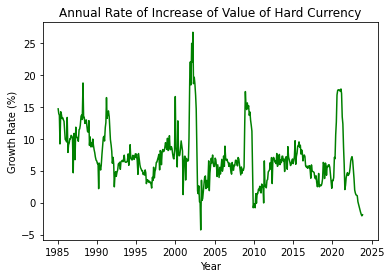

In [61]:
#Plotting Annual Growth Rate
money_production['Growth_Rate'] = money_production['Total'].pct_change(periods=12) * 100
plt.plot(money_production["Growth_Rate"], color = "green")
plt.title("Annual Rate of Increase of Value of Hard Currency")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")

We still see that our graph is quite jittery. We will take the moving average of this data with the average of the previous three datapoints to smooth our data.

Text(0, 0.5, 'Growth Rate (%)')

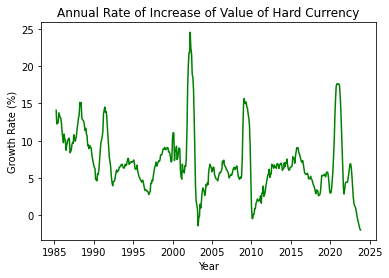

In [62]:
#Smoothing the Graph
money_production['Moving Avg'] = money_production['Growth_Rate'].rolling(window=3).mean()
plt.plot(money_production['Moving Avg'], color = "green")
plt.title("Annual Rate of Increase of Value of Hard Currency")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")

We see that our graph is now more smooth. We can compare it to inflation.

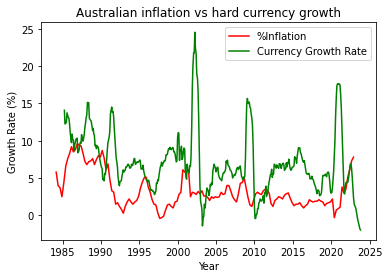

In [63]:
#Comparing Inflation to Money Supply
start_date = '1984-01-01'
end_date   = '2023-01-09'
inflation_post1984 = inflation_data.query('index >= @start_date and index <= @end_date')
plt.plot(inflation_post1984["Year-ended inflation"], color = "red",  label = "%Inflation")
plt.plot( money_production["Moving Avg"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

We see that there is large peaks in the production of hard currency during recessions in 1987, 1991, 2001, 2008 and 2020. This growth in hard currency is due to several factors. One of these includes people hoarding cash during those periods due the uncertainty in the economy.This does not increase inflation since people are just exchanging their digital cash in government bonds and stocks for hard physical cash. There is however an inflationary element too, as governments do indeed increase spending during recessions to bail banks as well as increase their welfare spending on the emerging unemployed. 

Indeed we see that inflation decreases during these years whilst there is a significant spike in the growth of hard cash. Maybe inflation is being dampened by factors which are devaluing money during a recession. People will naturally value money more in a recession. This is since debt has become a bigger burden, so people will see that they must pay more of what they are owed. This will thus dampen the increase in inflation that would be created by the sudden shock of hard currency in the economy. The "value" of debt can be changed depending on the interest rate set by the RBA. This will be reviewed later on. 

One way to look at the "value" of debt, we can look at the debt to income ratio. This is simple 


We also recognise that the increase in the money supply is increasingly done electronically rather than physically. We can see the evolution of zero-cash purchases from 2007 to 2022 using this graph here. We see that the amount of low cash users is increasing at a fast rate, and makes up 70% of total purchases in 2022. 70 percent of people therefore rely on their credit or debit cards for more than 80% of their purchases. We therefore see how the production of hard currency impacts inflation less from 1990-2023, as the increase in banknotes can be more attributed to cash withdrawals from ATM's, which do not impact inflation at all due to not increasing the money supply. 



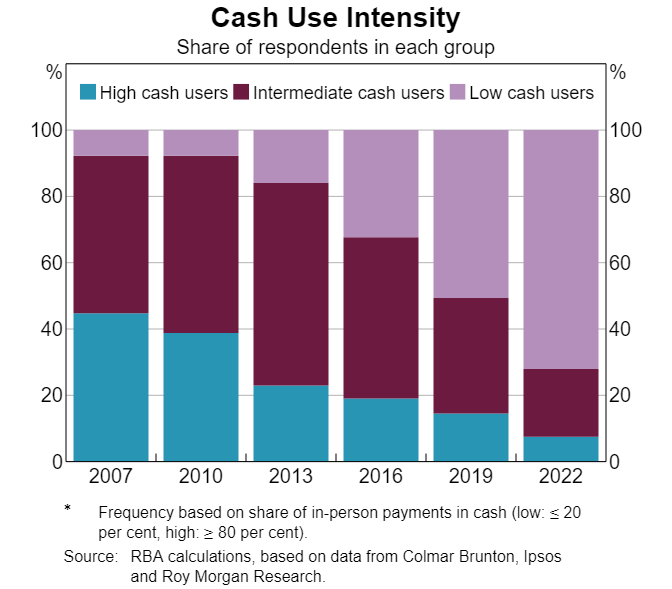

We will examine the money production before the year 1984. During that period, the usage of credit cards was more limited, so therefore the increase in hard money can mostly be explained by supplying new money into the economy. Australians only had electronic credit cards from 1974 onwards.

In [64]:
#Money production pre 1984
money_production_pre1984 = pd.read_csv("moneyproduction_pre1984.csv")
money_production_pre1984["Date"] = pd.to_datetime(money_production_pre1984["Date"], format='%d/%m/%Y')
money_production_pre1984.set_index("Date", inplace=True)
money_production_pre1984['Growth_Rate'] = money_production_pre1984['Total'].pct_change(periods=1) * 100

In [65]:
money_production_pre1984

,1$,2$,5$,10$,20$,50$,Total,Growth_Rate
Date,,,,,,,,
1945-07-31,16,149,NaN,147,50,NaN,362,NaN
1946-06-24,16,143,NaN,158,79,NaN,397,9.668508
1947-06-25,16,133,NaN,158,97,NaN,405,2.015113
1948-06-30,17,128,NaN,154,91,NaN,391,-3.456790
1949-06-29,17,130,NaN,170,108,NaN,425,8.695652
1950-06-28,17,132,NaN,189,124,NaN,462,8.705882
1951-06-27,18,137,NaN,234,160,NaN,550,19.047619
1952-06-25,19,136,NaN,282,167,NaN,604,9.818182
1953-06-24,20,135,NaN,318,183,NaN,656,8.609272


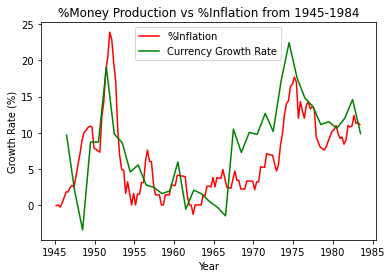

In [66]:
#Comparing Inflation to Hard Money Supply pre 1984
start_date = '1945-01-01'
end_date   = '1983-06-30'

inflation_pre1984 = shorten(inflation_data, start_date, end_date)
plt.plot(inflation_pre1984["Year-ended inflation"], color = "red", label = "%Inflation")
plt.plot(money_production_pre1984["Growth_Rate"], color = "green", label = "Currency Growth Rate")
plt.title("%Money Production vs %Inflation from 1945-1984")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

Apart from the period immediately after World War Two and in 1966, we can see that inflation rate and the annual growth of money in circulation have a definite relationship. 

We recongise that there seems to be a lag in the data by six months. This is because the inflation data is graphing year ending inflation based on data in December. However, our currency growth rate is graphing data each July. We can make sure that both of our data is at the same period by shifting our currency growth rate to the right.

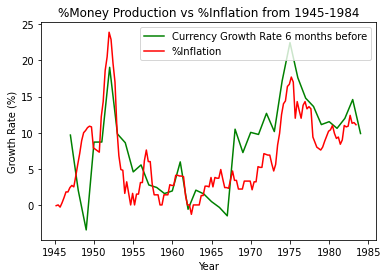

In [67]:
money_production_pre1984_shift6M = money_production_pre1984.copy()
money_production_pre1984_shift6M.index = money_production_pre1984_shift6M.index + pd.DateOffset(months=6)

ax1, = plt.plot(money_production_pre1984_shift6M["Growth_Rate"], color = "green",  label = "Currency Growth Rate 6 months before")
ax2, = plt.plot(inflation_pre1984["Year-ended inflation"], color = "red", label = "%Inflation")

plt.title("%Money Production vs %Inflation from 1945-1984")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

As you can see, both of these graphs are now more closely related than before.

### Analysis of Graph
This graph is looking at a period of 40 years. This is substantial enough time to notice that there is a long-term relationship between annual hard currency production and inflation for this particular data. We can see however that there is a definite anomaly in the period immediately after World War Two, and from 1966-1970. 

When we quantitatively compute the correlation between our two variables using an accepted formula (insert formula and reasoning here), we get a correlation of about 0.68. This is accepted as being a "strong" (Taylor) correlation.  When we remove the anomaly of the years immediately after World War Two, we get a even stronger correlation of 0.75. This proves our visual intuition that the growth of hard currency and inflation have strong effect on each other. 

We have to understand that the period immediately after World War Two was one of significant upheaval in the Australian economy. It needed to transition itself from a wartime economy back to a civilian one. The significant inflation after World War Two was due to the government's large government spending to finance the war effort, as well as the sudden release of price ceilings for goods. It was also due to a shortage of those said goods due to factories diverting their production to war material (Australia). This was a perfect storm to drive inflation upwards, even according to Monetarist Theory.

Similarly, the government significantly decreased its spending after World War Two. Indeed, Australia's government spending to GDP declined by about 60% from the end of World War Two to 1949 (Verrender). This was since the government no longer had to pay the huge wartime expenses for soldiers and war munitions.

Based on this analysis, we can  say that the anomaly in our graph after World War Two was due to the short term effects of transitioning to a civilian economy from a wartime one. We can compare this to today, where we are still recovering from the effects of a closed economy and huge government spending during the pandemic.

The sudden increase in the growth rate of hard currency in 1966 is due to Australia replacing all its hard cash from the British Pound to the Australian Dollar.  This is perhaps why in the period immediately after 1966 we see a bigger difference between inflation and the production of hard currency than before. As mentioned earlier, replacing existing money does not impact inflation at all. From 1966, the Royal Australian Mint was replacing money as well as increasing it. 

In [68]:
corr = fit_correlation(money_production_pre1984, "Growth_Rate", inflation_pre1984, 6)

print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : 0.6790468693305687


In [69]:
#Calculating Correlation excluding wwii effects
start_date = '1949-01-01'

money_production_pre1984_post1949 = money_production_pre1984.query('index >= @start_date')

corr = fit_correlation(money_production_pre1984_post1949, "Growth_Rate", inflation_pre1984, 6)

print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : 0.7483603579578613


Due to the high correlarity, we will extend this graph with our other data on a yearly basis. We will just plot our yearly data from 1984-2000 for the production of hard currency.

In [70]:
money_production_July=  money_production.query('index.dt.month in [6]')
money_production_July = pd.concat([money_production_pre1984, money_production_July])
money_production_July['Growth_Rate'] = money_production_July['Total'].pct_change(periods=1) * 100

In [71]:
money_production_July

,1$,2$,5$,10$,20$,50$,Total,Growth_Rate,100$,Moving Avg
Date,,,,,,,,,,
1945-07-31,16.0,149.0,NaN,147,50,NaN,362,NaN,NaN,NaN
1946-06-24,16.0,143.0,NaN,158,79,NaN,397,9.668508,NaN,NaN
1947-06-25,16.0,133.0,NaN,158,97,NaN,405,2.015113,NaN,NaN
1948-06-30,17.0,128.0,NaN,154,91,NaN,391,-3.456790,NaN,NaN
1949-06-29,17.0,130.0,NaN,170,108,NaN,425,8.695652,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-06-30,NaN,NaN,1003.0,1340,3337,38201.0,80024,5.900880,36144.0,5.712067
2020-06-30,NaN,NaN,1033.0,1386,3631,43626.0,90102,12.593722,40426.0,10.027196
2021-06-30,NaN,NaN,1023.0,1378,3581,46181.0,95485,5.974340,43322.0,8.981309


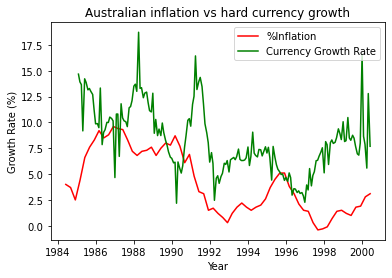

In [72]:
#Comparing Inflation to Money Supply 2000
start_date = '1984-06-01'
end_date = '2000-06-01'
inflation_pre2000_post1984 = inflation_data.query('index >= @start_date and index <= @end_date')
money_production_pre2000 = shorten(money_production, start_date, end_date)

plt.plot(inflation_pre2000_post1984["Year-ended inflation"], color = "red",  label = "%Inflation")
plt.plot( money_production_pre2000["Growth_Rate"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

As one can see, there is still a general relationship between the annual increase in hard cash, and the consequent increase in the inflation rate. The correlation of our graph as a whole is 0.4. This is only a moderate correlation. We notice that plotting just the annual change of hard currency growth from each year has smoothed out the variability in our data. We will smooth our the graph even more by computing the rolling average of the three previous datapoints.


In [73]:
#Correlation of new data
corr = fit_correlation(money_production_pre2000, "Growth_Rate", inflation_pre2000_post1984,6)
print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : 0.4157683489968525


C:\Users\Bat56\AppData\Local\Temp/ipykernel_17392/839663592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_production_pre2000['Moving Avg'] = money_production_pre2000['Growth_Rate'].rolling(window=2).mean()


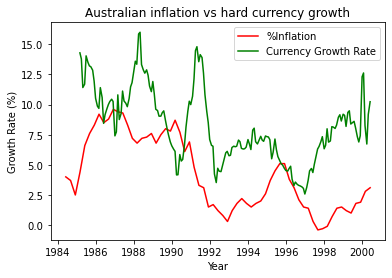

In [74]:
# Smoothing out Currency Growth pre-2000
money_production_pre2000['Moving Avg'] = money_production_pre2000['Growth_Rate'].rolling(window=2).mean()
plt.plot(inflation_pre2000_post1984["Year-ended inflation"], color = "red",  label = "%Inflation")
plt.plot( money_production_pre2000["Moving Avg"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

We see that our currency growth rate is more stable and closer to our inflation data. We get a correlation of 0.45, which is moderate. We can further extend this graph to the present day. We realize that we just needed to remove the seasonality of our currency growth rate by recording yearly instead of monthly data in order to get a closer relationship between inflation and the increase of hard currency in the long run.

In [75]:
#New Correlation
corr = fit_correlation(money_production_pre2000, "Moving Avg", inflation_pre2000_post1984, 6)
print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : 0.42883235500562067


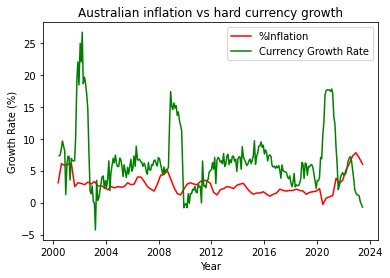

In [76]:
#Comparing Inflation to Money Supply to present
start_date = '2000-06-01'
end_date = '2023-06-01'
inflation_pre2023_post2000 = inflation_data.query('index >= @start_date and index <= @end_date')
money_production_pre2023 = shorten(money_production, start_date, end_date)

plt.plot(inflation_pre2023_post2000["Year-ended inflation"], color = "red",  label = "%Inflation")
plt.plot( money_production_pre2023["Growth_Rate"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

We will compute the rolling average of this currency growth rate to remove the dramatic peaks in our data.

C:\Users\Bat56\AppData\Local\Temp/ipykernel_17392/2588497566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_production_pre2023['Moving Avg'] = money_production_pre2023['Growth_Rate'].rolling(window=3).mean()


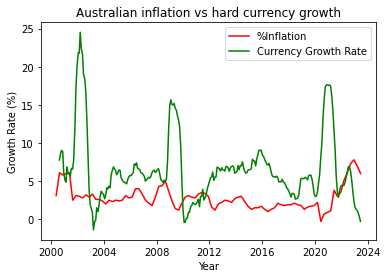

In [77]:
#Moving Average
money_production_pre2023['Moving Avg'] = money_production_pre2023['Growth_Rate'].rolling(window=3).mean()
plt.plot(inflation_pre2023_post2000["Year-ended inflation"], color = "red",  label = "%Inflation")
plt.plot( money_production_pre2023["Moving Avg"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

In [78]:
corr = fit_correlation(money_production_pre2023, "Moving Avg", inflation_pre2023_post2000, 6)
print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : -0.14202138639990358


We see that the correlation of our data is now only 0.2. This is a weak correlation. It therefore is not very reliable to use a a metric to predict recent data. 

We will finally compare together various metrics of inflation with the production of hard currency on a graph.

C:\Users\Bat56\AppData\Local\Temp/ipykernel_17392/1620136882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_production_pre2023['Moving Avg'] = money_production_pre2023['Growth_Rate'].rolling(window=3).mean()


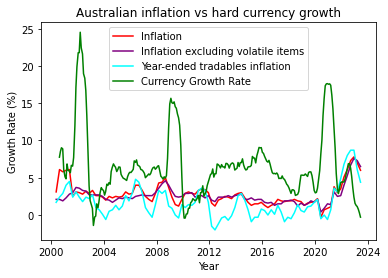

In [79]:
money_production_pre2023['Moving Avg'] = money_production_pre2023['Growth_Rate'].rolling(window=3).mean()
plt.plot(inflation_pre2023_post2000["Year-ended inflation"], color = "red",  label = "Inflation")
plt.plot(inflation_pre2023_post2000["Year-ended inflation – excluding volatile items"], color = "purple",  label = "Inflation excluding volatile items")
plt.plot(inflation_pre2023_post2000["Year-ended tradables inflation"], color = "cyan",  label = "Year-ended tradables inflation")
plt.plot( money_production_pre2023["Moving Avg"], color = "green", label = "Currency Growth Rate")
plt.title("Australian inflation vs hard currency growth")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.legend()

We can see that no matter what metric for inflation you have, there is no clear correlation between the currency growth rate and inflation for our present period.

### Further Analysis: Investigating Digital Money

We have found that the growth in physical cash has a very strong correlation with inflation throughout most of the period from 1945-1984. We realize the the increase in the money supply into the economy is now increasingly done digitally instead of physically. Digital money is supplied for example when the government lends money to banks. This is achieved via banks borrowing funding from the money printed by the RBA at low cost. We can examine this by looking at the total liabilities claimed by the Australian Government from 2007 to the present. This will show the total amount of interest owed by banks to the government due to loans being issued. 

In [80]:
#RBA Assets
liabilities_GOV = pd.read_csv("RBA Liabilities.csv")
liabilities_GOV["Date"] = pd.to_datetime(liabilities_GOV["Date"], format='%d/%m/%Y')
liabilities_GOV.set_index("Date", inplace=True)

Text(0, 0.5, 'Liabilities ($million)')

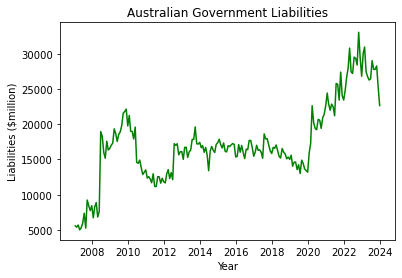

In [81]:
plt.plot( liabilities_GOV["Liabilities ($Million)"], color = "green")
plt.title("Australian Government Liabilities")
plt.xlabel("Year")
plt.ylabel("Liabilities ($million)")

As we can see, the total amount of assets has increase dramatically when the pandemic hit. Lets plot government liabilites against inflation. We will normalize the data so that it is on the same scale.

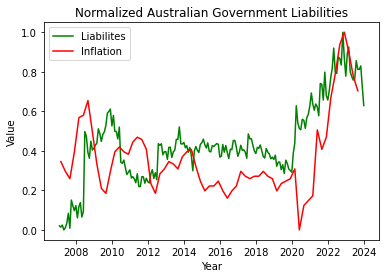

In [82]:
start_date = "2007-01-01"
inflation_post2007 = shorten(inflation_data, start_date)

inflation_normalized_post2007 = normalize(inflation_post2007)
liabilities_GOV_normalized = normalize(liabilities_GOV)

plt.plot(liabilities_GOV_normalized['Liabilities ($Million)'], color = "green", label = "Liabilites")
plt.plot(inflation_normalized_post2007["Year-ended inflation"], color = "red",  label = "Inflation")
plt.title("Normalized Australian Government Liabilities")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

As we can see, there seems to be a definite correlation. There are however clear anomalies in 2009, 2011, and 2020. Two of three of these periods are times of large government spending in the face of a global recession. This will mean that banks are bailed out by the government, so liabilities to the government would increase. Meanwhile, inflation is decreasing as demand for money declines during a recessionary period. However immediately after that period, inflation once again catches up. 


#### Conclusion
We have discovered that the growth of printing of hard currency in each year has a strong correlation with the inflation rate of about 0.7 from 1945-1984, however dramatically gets weaker afterwards. This is probably due to people using other payment methods. We have analysed some example of when we see that there is an opposite relationship between the graphs; such as the period immediately after WWII and the period of changing currency immediately after 1966. We have determined that these factors are temporary, and do not influence the eventual directory of inflation and the currency growth rate in the long term.

These results show that we should definitely explore the effects of money creation and subsequent inflation. However, we should look at other digital methods other than directly creating coins and banknotes for predicting our recent cost of living crisis.

### Interest Rates
We will now examine how the interest rate in the economy affects inflation. The interest rate (also known as the cash rate) is the rate that banks will have to pay in order to borrow funds from other banks set by the RBA. If the interest rate is low, then banks can borrow more money. This means that customers of those banks will be able to borrow more due to the bank setting lower interest rates for them too. This is since the banks can now sustain the greater risk involved as they have more capital. When people and organisations borrow more, the value of money decreases as the there is less money needed to be paid back on their loans in the same period of time. This will therefore cause inflation. Similarly, if interest rates increase, then citizens can borrow less, resulting in them saving more. This therefore causes deflation.

We will firstly plot the interest rate every year from 1990 and compare it with the inflation rate. 

In [83]:
#Interest Rate
interest_rate = pd.read_csv("interest_rate_post_1990.csv")
interest_rate["Date"] = pd.to_datetime(interest_rate["Date"], format='%d-%b-%y')
interest_rate.set_index("Date", inplace=True)
interest_rate;

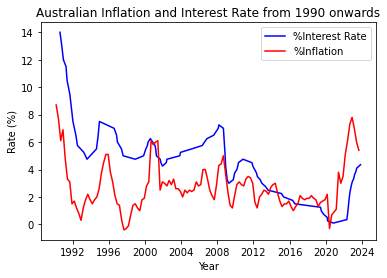

In [84]:
#Plotting Interest Rate and Inflation
start_date = '1990-01-01'

inflation_data_post_1990 = inflation_data.query('index >= @start_date')

ax1, = plt.plot(interest_rate["%Interest Rate"], color = "Blue",  label = "%Interest Rate")
ax2, = plt.plot(inflation_data_post_1990["Year-ended inflation"], color = "red", label = "%Inflation")

plt.title("Australian Inflation and Interest Rate from 1990 onwards")
plt.xlabel("Year")
plt.ylabel("Rate (%)")
plt.legend()

Just like with inflation earlier, we will shift our interest rate by 6 months to see if the "long run" impact of interest rates changes inflation as expected.

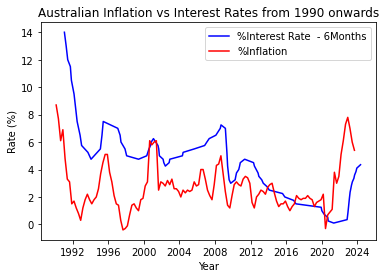

In [85]:
#Shifting Interest Rates
interest_shift6M = interest_rate.copy()
interest_shift6M.index = interest_shift6M.index + pd.DateOffset(months=6)

ax1, = plt.plot(interest_shift6M["%Interest Rate"], color = "Blue",  label = "%Interest Rate  - 6Months")
ax2, = plt.plot(inflation_data_post_1990["Year-ended inflation"], color = "red", label = "%Inflation")

plt.title("Australian Inflation vs Interest Rates from 1990 onwards")
plt.xlabel("Year")
plt.ylabel("Rate (%)")
plt.legend()

We can see that the desired impacts are still not felt. Lets shift the graph by 1 year (12 months).

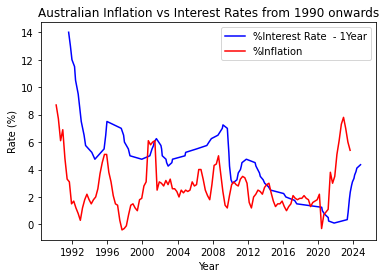

In [86]:
#Shifting Interest Rates
interest_shift1Y = interest_rate.copy()
interest_shift1Y.index = interest_shift1Y.index + pd.DateOffset(months=12)

ax1, = plt.plot(interest_shift1Y["%Interest Rate"], color = "Blue",  label = "%Interest Rate  - 1Year")
ax2, = plt.plot(inflation_data_post_1990["Year-ended inflation"], color = "red", label = "%Inflation")

plt.title("Australian Inflation vs Interest Rates from 1990 onwards")
plt.xlabel("Year")
plt.ylabel("Rate (%)")
plt.legend()

We now see enough of a substantial trend to determine that when interest rates are in one direction inflation will eventually go in the opposite direction after one year. We however see an anomaly during the 2010's, where interest rates were continuously decreased, but inflation was stagnant at 2%. We also see that when interest rates are higher to start with, there will be more of a significant change in inflation when they are changed. For example in the late 1990's, an increase in interest rates by 2% from 6-4% yielded a 5% decline in inflation the next year. However, when we increase interest rates by 1.25% in 2011-12 from 3-4.25%, inflation only declined by 1% the next year instead of 2.75% which should have been expected.



#### Conclusion
We have found that increasing interest rates seems to mostly have the desired effect of decreasing inflation one year later. However, it is more potent if interest rates are high to start with. We see an anomaly in the 2010's, that interest rates are very low but inflation seems to be consistent at 2%. 

### Government Bonds
Another way that we can track money printing, is the purchase of Government Bonds by the RBA from banks and institutions. This increases the capital in those banks, which means they will loan more money to individuals and consumers just like when the government changes interest rates. An increase in the borrowing of Government Bonds should drive inflation upwards, and a decrease should decrease inflation. 

We will start by plotting the total Government Bonds held by the RBA each month from 2017 to the present day. This was the only data that was available.

In [87]:
#Government Bonds Data
Gov_Bonds = pd.read_csv('Government Bonds.csv')
Gov_Bonds["Date"] = pd.to_datetime(Gov_Bonds["Date"], format='%d-%b-%Y')
Gov_Bonds.set_index("Date", inplace=True)

In [88]:
Gov_Bonds;

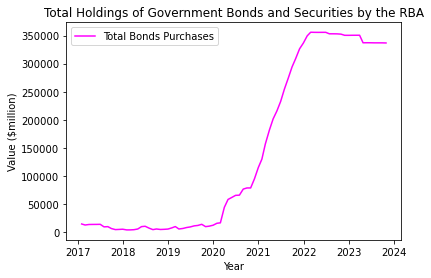

In [89]:
#Plotting Government Bonds 

ax1, = plt.plot(Gov_Bonds["Total Bonds and Securities ($million)"], color = "Magenta",  label = "Total Bonds Purchases")
plt.title("Total Holdings of Government Bonds and Securities by the RBA")
plt.xlabel("Year")
plt.ylabel("Value ($million)")
plt.legend()

We can see that there was a dramatic increase in government bonds held during the pandemic. It rose from about 14 billion at the start of 2020, to $350 billion by the end of 2021. Lets now plot the inflation rate. We will normalize this data so that both are on the same scale.

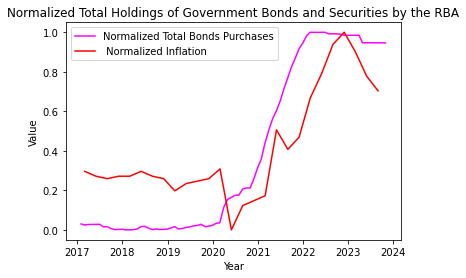

In [90]:
#Plotting Normalized Government Bonds against inflation
Gov_Bonds_normalized = (Gov_Bonds - Gov_Bonds.min()) / (Gov_Bonds.max() - Gov_Bonds.min())

start_date = '2017-01-01'

inflation_post2017 = inflation_data.query('index >= @start_date')
inflation_normalized_post2017 = normalize(inflation_post2017)


ax1, = plt.plot(Gov_Bonds_normalized["Total Bonds and Securities ($million)"], color = "Magenta",  label = "Normalized Total Bonds Purchases")
ax2, = plt.plot(inflation_normalized_post2017["Year-ended inflation"], color = "Red",  label = " Normalized Inflation")
plt.title("Normalized Total Holdings of Government Bonds and Securities by the RBA")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()


As we can see, there is a relationship between the total bonds purchased and inflation. However, there is a lag of about six months between the change in bond purchases, and the subsequent change in inflation.  This is shown by this graph. 

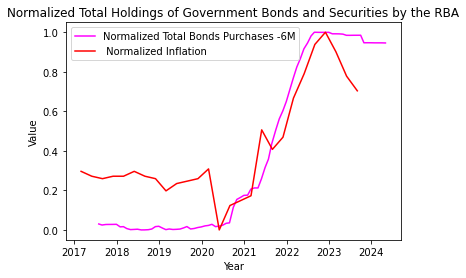

In [91]:
#Shifting Data
Gov_Bonds_normalized_shift6M = Gov_Bonds_normalized.copy()
Gov_Bonds_normalized_shift6M.index = Gov_Bonds_normalized_shift6M.index + pd.DateOffset(months=6)

ax1, = plt.plot(Gov_Bonds_normalized_shift6M["Total Bonds and Securities ($million)"], color = "Magenta",  label = "Normalized Total Bonds Purchases -6M")
ax2, = plt.plot(inflation_normalized_post2017["Year-ended inflation"], color = "Red",  label = " Normalized Inflation")
plt.title("Normalized Total Holdings of Government Bonds and Securities by the RBA")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()


When we shift by 6 months, the inflation rate lies closer to the total bond purchases. 

We see that very recently inflation has been decreasing whilst the total bond purchases have remained stagnant.  This is an anomaly in the graph, 

## Keynesian Perspective
Keynesians believe that inflation is caused by is the consumption in the economy. 

According to Keynesianists, our diagram looks like this...

### Insert Diagram 3

We can see that our LRAS (Long Run Aggregate Supply) curve is curved rather than vertically straight. This is since they believe that printing money during a recessionary period does not necessarily increase inflation (when the AD curve shifts to the left). In a recession, even if printing money does increase consumer demand, businesses have the capacity to produce more goods already due to having to produce at higher demand in better periods (having spare machinery available, spare offices which were once occupied by workers ect). They therefore can produce enough goods to fuel the increasing demand. However, in periods of relative prosperity, printing money puts pressure on businesses which do not have the resources to compete. They will therefore have no choice but to raise prices to slow demand. This occurs in the Long Term. In economics, this specifies when the economy has begun its transition out of the recession. For example when employment starts to increase.

When we look at the diagram shown previously, we assumed that the money demanded stayed the same. What if it increased?

### Insert Diagram 4

We can see that when the money demanded increases and our money supply does not, our AD (or Aggregate Demand) curve shifts to the right. Consequently, the equillibrium for the value for money increases as well, and thus inflation occurs. They believe that the money demanded is not static and fluctuates depending on economic conditions. Increasing Aggregate demand causes inflation.

Aggregate Demand increases when consumers spend more money than previously on factors of production (land, labour, capital, and entrepreneurship) in an economy. This means that they save less and spend more. This can happened for several reasons. Firstly if the Government implements a loose monetary policy. This occurs when interest rates are lowered and taxes are decreased. This allows the citizen to spend more money on other things. It can also happened when there is an increase in the population of the country. This means more customers consuming. 

We can measure the Aggregate Demand in the economy by looking at the GDP (Gross Domestic Product) of a country. This describes the total value of goods and services that are produced in an economy domestically which is effectively the Keynesian Aggregate Demand. It looks at domestic investment, revenue from exports minus imports, as well as consumer and government spending. We will examine GDP and also other possible factors that could cause inflation based on their model.

The RBA  has GDP data avaliable. We will graph the Real GDP (GDP adjusted for inflation) for Australia every year from the first of September 1959 to the present day. 


### GDP Data
We will firstly graph read GDP (GDP adjusted for inflation) in Australia from 1959 to the present.

In [92]:
#Reading GDP Data
GDP = pd.read_csv("GDP_data.csv")
GDP["Date"] = pd.to_datetime(GDP["Title"], format='%d/%m/%Y')
GDP = GDP.drop(["Title"], axis = 1)
GDP.set_index('Date', inplace=True)
GDP

,Real GDP,Year-ended real GDP growth,Real non-farm GDP,Year-ended real non-farm GDP growth,Real farm GDP,Year-ended real GDP per capita growth,Real GDI,Year-ended real GDI growth,Nominal GDP,Year-ended nominal GDP growth,Terms of trade
Date,,,,,,,,,,,
1959-09-01,68834.0,NaN,59948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-12-01,69442.0,NaN,60478.0,NaN,NaN,NaN,60931.0,NaN,3973.0,NaN,59.6
1960-03-01,69787.0,NaN,60775.0,NaN,NaN,NaN,61534.0,NaN,4089.0,NaN,58.5
1960-06-01,71718.0,NaN,62749.0,NaN,NaN,NaN,62438.0,NaN,4168.0,NaN,62.2
1960-09-01,71878.0,4.4,64278.0,7.2,NaN,NaN,64215.0,NaN,4378.0,NaN,62.8
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,553036.0,5.9,539863.0,6.0,13423.0,2.0,570624.0,4.9,611328.0,11.7,118.1
2022-12-01,555690.0,2.7,542871.0,3.0,13173.0,4.2,566449.0,5.9,618436.0,13.3,111.1
2023-03-01,NaN,NaN,NaN,NaN,12819.0,0.8,570026.0,4.4,631402.0,12.0,111.7


Text(0, 0.5, 'Value (in $ AUD)')

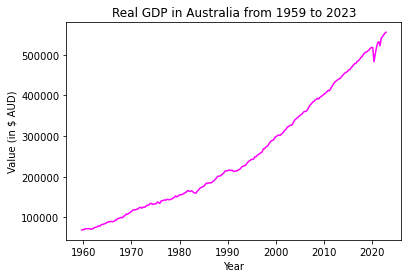

In [93]:
#Plotting GDP Data
plt.plot(GDP["Real GDP"], color = 'magenta')
plt.title("Real GDP in Australia from 1959 to 2023")
plt.xlabel("Year")
plt.ylabel("Value (in $ AUD)")

We can see that GDP has always generally been increasing up until the Covid-19 Pandemic in 2020. Lets now analyse the GDP growth over the same period.

Text(0, 0.5, '%Growth')

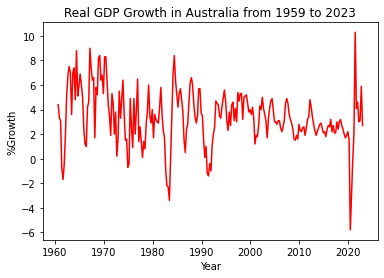

In [94]:
#Plotting GDP Data
plt.plot(GDP["Year-ended real GDP growth"], color = 'r')
plt.title("Real GDP Growth in Australia from 1959 to 2023")
plt.xlabel("Year")
plt.ylabel("%Growth")

We can see that GDP growth has been quite volative over the years. It is mostly hovering above zero however.
We will now graph inflation with GDP growth over the same period.

In [95]:
#Getting Inflation post 1959
start_date = '1959-09-01'
inflation_data_after_1959 = inflation_data.query('index >= @start_date')

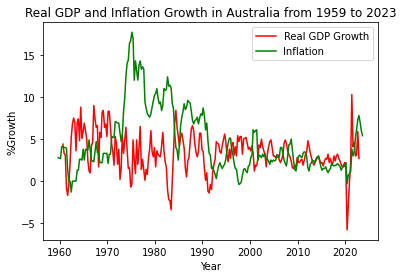

In [96]:
#Plotting GDP Data Against Inflation
plt.plot(GDP["Year-ended real GDP growth"], color = 'r', label = "Real GDP Growth")
plt.plot(inflation_data_after_1959["Year-ended inflation"], color = "g", label = "Inflation")
plt.title("Real GDP and Inflation Growth in Australia from 1959 to 2023")
plt.xlabel("Year")
plt.ylabel("%Growth")
plt.legend()

In [97]:
#Correlation between Real GDP Growth and Inflation
corr = inflation_data_after_1959["Year-ended inflation"].corr(GDP["Year-ended real GDP growth"])
print(f"The correlation between year-ended inflation and the growth rate of hard currency is : {corr}")

The correlation between year-ended inflation and the growth rate of hard currency is : -0.1643311242246639


we can see that there is no clear correlation between the two. Sometimes they are quite close, but at other times they are far apart. This is especially apparent in the 1970's, where there was high inflation, but GDP growth remained about the same. When we calculate the correlation between inflation and GDP growth, we get -0.3. This firstly shows that as inflation increased GDP growth actually declines. However this correlation is quite low.

GDP growth describe the "shift" in Aggregate Demand due to economic conditions. We can see that in 2020 for example, GDP growth dramatically declined due to a high unemployment rate and economic uncertainty during the start of the Pandemic. As said previously, if we increase the Aggregate Demand during a recession, the economy should eventually stabilize and there will be no inflation in the long run. Lets examine the period from the start of the Pandemic to today

In [98]:
GDP

,Real GDP,Year-ended real GDP growth,Real non-farm GDP,Year-ended real non-farm GDP growth,Real farm GDP,Year-ended real GDP per capita growth,Real GDI,Year-ended real GDI growth,Nominal GDP,Year-ended nominal GDP growth,Terms of trade
Date,,,,,,,,,,,
1959-09-01,68834.0,NaN,59948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-12-01,69442.0,NaN,60478.0,NaN,NaN,NaN,60931.0,NaN,3973.0,NaN,59.6
1960-03-01,69787.0,NaN,60775.0,NaN,NaN,NaN,61534.0,NaN,4089.0,NaN,58.5
1960-06-01,71718.0,NaN,62749.0,NaN,NaN,NaN,62438.0,NaN,4168.0,NaN,62.2
1960-09-01,71878.0,4.4,64278.0,7.2,NaN,NaN,64215.0,NaN,4378.0,NaN,62.8
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,553036.0,5.9,539863.0,6.0,13423.0,2.0,570624.0,4.9,611328.0,11.7,118.1
2022-12-01,555690.0,2.7,542871.0,3.0,13173.0,4.2,566449.0,5.9,618436.0,13.3,111.1
2023-03-01,NaN,NaN,NaN,NaN,12819.0,0.8,570026.0,4.4,631402.0,12.0,111.7


In [99]:
#GDP vs Inflation Pandemic to Present
start_date = '2019-12-31'
inflation_pandemic = inflation_data.query('Quarter >= @start_date')
GDP_pandemic = GDP.query('index >= @start_date')
                                          

plt.plot(GDP_pandemic["Year-ended real GDP growth"], color = 'r', label = "Real GDP Growth")
plt.plot(inflation_pandemic["Quarter"], inflation_pandemic["Year-ended inflation"], color = "g", label = "Inflation")
plt.title("Real GDP and Inflation Growth in Australia from 1959 to 2023")
plt.xlabel("Year")
plt.ylabel("%Growth")
plt.legend()


UndefinedVariableError: name 'Quarter' is not defined

We can see that during the initial part of the pandemic in March 2020, 

### Final Possible Factor: Unemployment Rate



## Bibliography
commerce, Kate O’Brien Kate O’Brien studies, et al. “What Is Quantitative Easing (QE) and How Does It Work?” The Motley Fool Australia, www.fool.com.au/definitions/quantitative-easing/#:~:text=example%20of%20QE-.

Reserve Bank of Australia. “Unconventional Monetary Policy.” Reserve Bank of Australia, www.rba.gov.au/education/resources/explainers/unconventional-monetary-policy.html. Accessed 29 July 2023.

Bellrose, Kellie, and Joyce Tan. “Bridging the Textbook Gaps on How the RBA Implements a Change to the Cash Rate | Teacher Updates | Education | RBA.” Reserve Bank of Australia, www.rba.gov.au/education/resources/teacher-updates/bridging-the-textbook-gaps-on-how-the-rba-implements-monetary-policy/. Accessed 29 July 2023.

Taylor, Richard. “Interpretation of the Correlation Coefficient: A Basic Review.” Journal of Diagnostic Medical Sonography, vol. 6, no. 1, Jan. 1990, pp. 35–39, journals.sagepub.com/doi/pdf/10.1177/875647939000600106, https://doi.org/10.1177/875647939000600106.

Rouse, Chair, et al. “Historical Parallels to Today’s Inflationary Episode.” The White House, 6 July 2021, www.whitehouse.gov/cea/written-materials/2021/07/06/historical-parallels-to-todays-inflationary-episode/#:~:text=%5B1%5D%20Prices%20also%20surged%20after. Accessed 5 Aug. 2023.

Bohanon, Cecil . “Economic Recovery: Lessons from the Post-World War II Period.” Mercatus Centre, 12 Sept. 2012, www.mercatus.org/research/policy-briefs/economic-recovery-lessons-post-world-war-ii-period#:~:text=In%201944%2C%20government%20spending%20at,by%20only%20around%2011%20percent. Accessed 5 Aug. 2023.

Australia, Reserve Bank of. “The Spectre of Inflation | Reserve Bank of Australia - Museum.” Museum.rba.gov.au, museum.rba.gov.au/exhibitions/make-your-money-fight/spectre-of-inflation/. Accessed 5 Aug. 2023.

Verrender, Ian. “Why Australia’s Government Debts and Budget Deficits Are Here to Stay.” Www.abc.net.au, 19 July 2020, www.abc.net.au/news/2020-07-20/why-debts-and-deficits-are-here-to-stay/12471300. Accessed 5 Aug. 2023.

https://www.aph.gov.au/About_Parliament/Parliamentary_departments/Parliamentary_Library/pubs/rp/BudgetReviewOctober202223/AustralianGovernmentDebt#:~:text=Since%20the%20beginning%20of%20the,as%20of%2028%20October%202022.

https://www.abs.gov.au/statistics/economy/government/taxation-revenue-australia/latest-release#:~:text=In%20the%20year%202021%2D22,%24683.0%20billion

https://www.imf.org/external/datamapper/GGXCNL_NGDP@WEO/AUS

https://www.commbank.com.au/articles/investing/what-are-government-bonds.html

https://www.rba.gov.au/education/resources/explainers/pdf/bonds-and-the-yield-curve.pdf?v=2023-11-18-19-00-48

https://banknotes.rba.gov.au/production-and-distribution/production/